# Affinity Propagation Clustering


This clustering method is like ``hierarchical clustering`` in the sense that you don't have to know the number of clusters beforehand. The main difference is that ``AP Clustering`` tries to find the clusters centers without having to use a dendrogram.

This method uses 4 concepts to find the centers (it works pretty well for small datasets since all the matrices are $(n,n)$:

* similarity (s): Represents the negative euclidean distance between all the data points (distance matrix).

  * For all $i = j$, a value is set manually for all $i,j$. This is called "the preference". The higher it is, the more clusters we will end up having, and the smaller it is, the fewer clusters we will end up having.

* responsibility (r): Represents how much influence a cluster k has on a data point i. It's represented as $r(i,k)=s(i,k) - max_{k' \ne k}(a(i,k')-s(i,k'))$

* availiability (a): Represents how likely the data point i is to choose k as its cluster (representative). It's represented as $a(i,k) = min\{0,r(k,k)+\sum_{i'\ne {i,k}}max\{0,r(i',k)\}\}, \ i \ne k$
$a(k,k)=\sum_{i'\ne {k}}max\{0,r(i',k)\}, i = k$

  * When updating $a$ and $r$, a "dumping value" $\lambda$ is chosen manually (0.5 is a common value). This prevents oscillations for each iteration $t$:

  <center>$r(i,k)_{t+1}=(1-\lambda)\cdot r(i,k)_{t+1} + \lambda \cdot r(i,k)_{t}$ </center>

  <center>$a(i,k)_{t+1}=(1-\lambda)\cdot a(i,k)_{t+1} + \lambda \cdot a(i,k)_{t}$ </center>
* criterion: it represents the sum of $r(i,k)$ and $a(i,k)$ for all $i,k$. The highest value for each row represents the cluster of that row.

The algorithm starts by calculating the ``distance_matrix``, starting the matrix for $a$ and $r$ on zero, and choosing a $\lambda$. Then the responsibility is calculated for all $i,j$, then the ``update formula`` is used. Afterwards, availibility is calculated and updated. Finally, the ``criterion matrix`` is found.

These steps are performed as many times as necessary.

Let's start by using ``make_blobs`` to create an artificial sample:

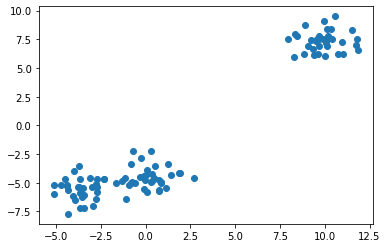

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist

cluster_a = make_blobs(100,2,random_state=2020)[0]
plt.scatter(cluster_a[:,0],cluster_a[:,1])

Now, let's make the algorithm using above's definitions:

In [3]:
s_matrix = -1*cdist(cluster_a,cluster_a,metric="euclidean")
matrix_shape = (len(s_matrix),len(s_matrix))
damping = 0.5 # Damping coefficient
for i in range(len(s_matrix)):
  s_matrix[i,i] = -50 # Preference

r_matrix_bef, a_matrix_bef = np.zeros(matrix_shape), np.zeros(matrix_shape)
r_matrix, a_matrix = np.zeros(matrix_shape), np.zeros(matrix_shape)

for loop in range(100):

  r_matrix_bef = r_matrix.copy()
  for i in range(len(s_matrix)):
    for j in range(len(s_matrix)):
      condition = s_matrix[i] != s_matrix[i,j]
      max = np.max(a_matrix[i][condition]+s_matrix[i][condition]) 
      r_matrix[i,j] = s_matrix[i,j] - max

  r_matrix = damping*r_matrix_bef + (1-damping)*r_matrix
  a_matrix_bef = a_matrix.copy()
  for i in range(len(s_matrix)):
    for j in range(len(s_matrix)):
      if i != j:
        condition = (r_matrix[:,j] > 0) & ((r_matrix[:,j] != r_matrix[i,j]) & (r_matrix[:,j] != r_matrix[j,j]))
        calc = r_matrix[j,j] + np.sum(r_matrix[:,j][condition])
        a_matrix[i,j] = np.min([calc,0])
      else:
        condition = (r_matrix[:,i] > 0) & (r_matrix[:,i] != r_matrix[i,i])
        calc = np.sum(r_matrix[:,i][condition])
        a_matrix[i,i] = calc

  a_matrix = damping*a_matrix_bef + (1-damping)*a_matrix
  c_matrix = a_matrix + r_matrix # criterion matrix

np.set_printoptions(precision=2)
print("Number of clusters: ",len(np.unique(np.argmax(c_matrix,axis=1))))
print("Cluster centres: ",np.unique(np.argmax(c_matrix,axis=1)))
print("Maximum values: ",c_matrix.max(axis=1))
print("Cluster beloging to maximum: ", np.argmax(c_matrix,axis=1))


Number of clusters:  3
Cluster centres:  [ 9 70 96]
Maximum values:  [1.33e+01 3.00e+00 1.28e+01 3.96e+00 4.47e+00 3.39e+00 4.30e+00 2.94e+00
 3.76e-01 3.98e+02 2.76e+00 1.41e+00 2.44e-01 2.44e+00 3.60e+00 1.31e+01
 2.30e+00 4.69e+00 1.29e+00 6.49e-01 3.14e+00 1.83e+00 1.15e+00 1.39e+01
 1.15e+01 9.86e-01 7.84e-01 6.38e-01 3.14e+00 1.37e+01 4.78e+00 1.37e+01
 3.10e+00 1.39e+01 1.39e+01 1.37e+01 1.36e+01 4.12e+00 1.39e+01 1.38e+01
 1.16e+01 1.39e+01 3.24e+00 4.29e+00 1.28e+01 1.22e+01 4.32e+00 4.25e+00
 4.08e+00 1.38e+01 4.09e+00 4.21e+00 1.37e+01 1.24e+01 1.53e+00 1.06e+01
 2.37e+00 1.29e+01 1.23e+01 4.12e+00 2.43e+00 1.29e+01 4.80e+00 2.44e+00
 1.39e+01 4.53e+00 2.83e+00 3.57e+00 4.54e+00 1.37e+01 6.14e+01 1.39e+01
 1.37e+01 2.19e+00 2.66e+00 1.22e+00 4.27e+00 4.12e+00 2.53e+00 2.70e+00
 3.62e+00 3.63e+00 3.08e+00 1.27e+01 3.29e+00 3.65e+00 1.25e+01 2.31e+00
 3.02e+00 4.05e+00 1.36e+01 1.29e+01 2.75e+00 4.11e+00 1.85e+00 4.48e+00
 4.08e+01 1.33e+01 4.71e+00 1.23e+00]
Cluster beloging 

Now we can plot the clusters and their centers:

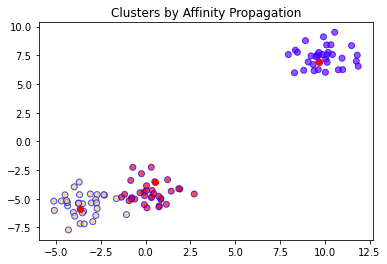

In [4]:
plt.title("Clusters by Affinity Propagation")
plt.scatter(cluster_a[:,0], cluster_a[:,1], c=np.argmax(c_matrix,axis=1), cmap='rainbow', alpha=0.7, edgecolors='b')
for center in np.unique(np.argmax(c_matrix,axis=1)):
  plt.scatter(cluster_a[center,0],cluster_a[center,1], c = "red")
plt.show()